In [20]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input, GetImgAndTextEmbs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

torch.cuda.is_available()

True

In [3]:
OUT_DIM=12
INPUT_DIM=128
BS= 8

In [4]:
dls = torch.load("./data/dls_sequence_from_embs.pth")

In [5]:
test_dl = torch.load("./data/test_dl_sequence_from_embs.pth")

In [6]:
dls.bs = dls.train.bs = dls.valid.bs = test_dl.bs = 8

In [16]:
class LSTMModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128):
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [17]:
model = LSTMModel(7936, 12)

In [9]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [23]:
learn = Learner(dls, model, loss_func=loss_func)
learn.load("best_sequence_from_embs128_moreEpochs")

In [24]:
learn.summary()

LSTMModel (Input shape: ['8 x 4242 x 7936'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
________________________________________________________________
Linear               8 x 4242 x 512       4,063,744  True      
________________________________________________________________
Linear               8 x 4242 x 12        3,084      True      
_____________________________________________________

In [27]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))
    return preds, targets

In [29]:
preds, targets = evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9613    0.8744    0.9158       199
B-agravo_em_recurso_extraordinario     0.6166    0.5587    0.5862       213
     B-despacho_de_admissibilidade     0.7965    0.6122    0.6923       147
                          B-outros     0.9326    0.8898    0.9107     25744
                   B-peticao_do_RE     0.8185    0.6506    0.7250       312
                        B-sentenca     0.8584    0.7547    0.8032       265
          I-acordao_de_2_instancia     0.6296    0.9189    0.7473        74
I-agravo_em_recurso_extraordinario     0.5512    0.6677    0.6039      1628
     I-despacho_de_admissibilidade     0.5000    0.4706    0.4848        51
                          I-outros     0.9275    0.9447    0.9360     59664
                   I-peticao_do_RE     0.7988    0.7937    0.7962      6019
                        I-sentenca     0.8822    0.8174    0.8486      1210

          

In [46]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *1--
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


<AxesSubplot:title={'center':' '}, xlabel='Predicted label', ylabel='True label'>

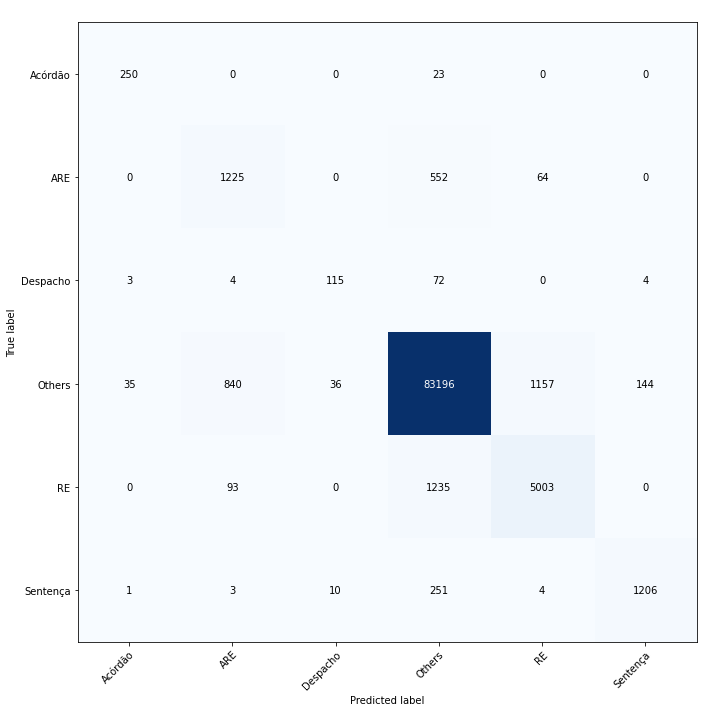

In [51]:
plot_confusion_matrix(targets, preds, ["Acórdão", "ARE", "Despacho", "Others", "RE", "Sentença"],
                      normalize=True, title=" ")